In [1]:
#!pip install pandas_datareader -q
#!pip install PyPortfolioOpt -q

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pypfopt
%load_ext autoreload
%autoreload 2


# Stock Selection

BRKA portfolio tracker: https://www.dataroma.com/m/holdings.php?m=BRK 

Here, we referred to the link above to identify what are the major components of the Berkshire Portfolio.

We try to select a manageable number of stocks, in this case 10, which are generally uncorrelated with each other to allow us to build a more stable portfolio.

In [3]:
start = datetime(2010, 1, 1)
symbols_list = ['AAPL', 'AXP', 'UAA', 'APA', 'SU', 'NFLX', 'XRX','AMZN', 'KO', 'TSLA']

symbols = []
for ticker in symbols_list:
    r = web.DataReader(ticker, 'yahoo', start)
    r["Symbol"] = ticker
    symbols.append(r)
    
eq_df = pd.concat(symbols).reset_index()
eq_df = eq_df[['Date', 'Adj Close', 'Symbol']]
eq_df.head()

,Date,Adj Close,Symbol
0,2009-12-31,6.492372,AAPL
1,2010-01-04,6.593426,AAPL
2,2010-01-05,6.604825,AAPL
3,2010-01-06,6.499768,AAPL
4,2010-01-07,6.487752,AAPL


In [4]:
eq_pivot = eq_df.pivot('Date', 'Symbol', 'Adj Close')
eq_pivot.head()

Symbol,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
Date,,,,,,,,,,
2009-12-31,6.492372,134.520004,86.816673,34.291534,18.804321,7.870000,25.900511,NaN,3.40875,16.380875
2010-01-04,6.593426,133.899994,89.088692,34.630035,18.817513,7.640000,26.964104,NaN,3.51000,16.710045
2010-01-05,6.604825,134.690002,90.140579,34.553879,18.589882,7.358572,27.338200,NaN,3.61500,16.729410
2010-01-06,6.499768,132.250000,91.554268,35.112431,18.583282,7.617143,27.881002,NaN,3.69500,16.574509
2010-01-07,6.487752,130.000000,90.165810,35.681915,18.537094,7.485714,27.514252,NaN,3.65125,16.651955


In [5]:
corr_matrix = eq_pivot.corr(method='pearson')
corr_matrix.head().reset_index()
corr_matrix

Symbol,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
Symbol,,,,,,,,,,
AAPL,1.000000,0.959127,-0.813438,0.766251,0.825692,0.921706,-0.214714,0.880826,0.001576,0.282111
AMZN,0.959127,1.000000,-0.845696,0.798816,0.846532,0.984514,-0.100152,0.780318,-0.033039,0.302081
APA,-0.813438,-0.845696,1.000000,-0.777576,-0.885974,-0.843699,0.216796,-0.586810,-0.283729,-0.369745
AXP,0.766251,0.798816,-0.777576,1.000000,0.921874,0.824764,0.243947,0.504735,0.245040,0.689028
KO,0.825692,0.846532,-0.885974,0.921874,1.000000,0.844583,0.053362,0.581995,0.311232,0.572401
NFLX,0.921706,0.984514,-0.843699,0.824764,0.844583,1.000000,-0.000110,0.712565,-0.004456,0.371971
SU,-0.214714,-0.100152,0.216796,0.243947,0.053362,-0.000110,1.000000,-0.424052,0.013599,0.522297
TSLA,0.880826,0.780318,-0.586810,0.504735,0.581995,0.712565,-0.424052,1.000000,-0.062603,0.047680
UAA,0.001576,-0.033039,-0.283729,0.245040,0.311232,-0.004456,0.013599,-0.062603,1.000000,0.410798


# Correlation heatmap

We can verify that we got a good mix of stocks which do not have a general tendencey to follow the same direction with each other

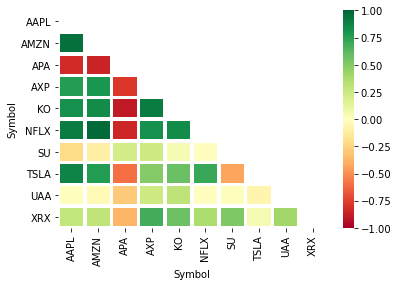

In [6]:
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
#generate plot
sns.heatmap(corr_matrix, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

# Wealth Plot

The wealth plot tells us how how much we would have at a point t in time, if we were to buy and hold

In [22]:
spy_data = web.DataReader('SPY', 'yahoo', '2010-01-02') # 1) Load web data
brka_data = pd.read_csv("data/BRK-A.csv", parse_dates=True, index_col=0) # 2) Load csv
brka_data.index = pd.to_datetime(brka_data.index, format="%Y-%m-%d")
brka_recent = brka_data["2010":]

spy_data["rets"] = (spy_data["Close"] - spy_data["Open"]) / spy_data["Open"] # Take note here, adjusted close should be used instead
brka_recent["rets"] = (brka_recent["Adj Close"] - brka_recent["Open"]) / brka_recent["Open"]


C:\Users\Marcus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


<AxesSubplot:xlabel='Date'>

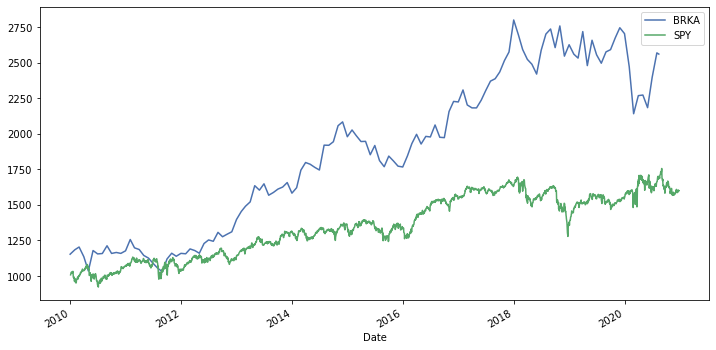

In [23]:
spy_wealth = 1000*(1+spy_data["rets"]).cumprod()
brka_wealth = 1000*(1+brka_recent["rets"]).cumprod()
brka_wealth.plot.line(label="BRKA", legend=True, figsize=(12,6))
spy_wealth.plot.line(label="SPY", legend=True)

In [24]:
import utils as utils
rfr = 1.02**(1/252)-1 # PyPortfolioOpt default rate for consistency
brk_rets = utils.annualize_rets(brka_recent["rets"], 12)
brk_vol = utils.annualize_vol(brka_recent["rets"], 12)
brk_sharpe = utils.sharpe_ratio(brka_recent["rets"],rfr, 12)
print("Berkshire Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (brk_rets, brk_vol, brk_sharpe))

Berkshire Analysis:
	Expected annual return: 0.091372
	Annual Volatility: 0.157096
	Sharpe ratio: 0.581088


# Efficient Frontier
I have extracted a summary of what is Efficient Frontier from investopedia's website https://www.investopedia.com/terms/e/efficientfrontier.asp

"What Is the Efficient Frontier?
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return."

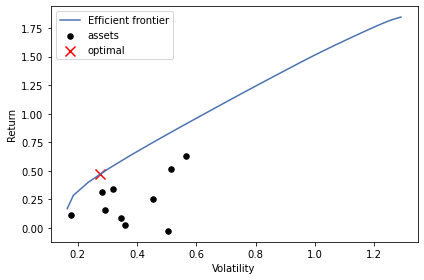

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

In [25]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import cla
# Read in price data

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(eq_pivot)
S = risk_models.sample_cov(eq_pivot)

# Optimise for maximal Sharpe ratio
cla = cla.CLA(mu, S, weight_bounds=(-1,1))
plotting.plot_efficient_frontier(cla, points=100, show_assets=True)

In [26]:
weights_df = pd.DataFrame(mu.index)
weights_df["Weights"] = cla.weights
weights_df

,Symbol,Weights
0,AAPL,0.404173
1,AMZN,0.189641
2,APA,-0.151316
3,AXP,0.068222
4,KO,0.348251
5,NFLX,0.167782
6,SU,-0.146276
7,TSLA,0.226479
8,UAA,0.064172
9,XRX,-0.171127


In [27]:
print("EF Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (cla.portfolio_performance()))
print("Berkshire Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (brk_rets, brk_vol, brk_sharpe))

EF Portfolio Analysis:
	Expected annual return: 0.469901
	Annual Volatility: 0.274022
	Sharpe ratio: 1.641844
Berkshire Analysis:
	Expected annual return: 0.091372
	Annual Volatility: 0.157096
	Sharpe ratio: 0.581088
